Getting vd and ages from Rvar vs teff. The bin sizes are in [16]

In [13]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

With Rvar and Prot

In [14]:
df_rvar=pd.read_pickle('Rvars.pkl')

# read in McQuillian stars
McQS = pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','Rper','LPH','w','DC','Flag'))
MCQS_t2=pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_2_Non_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','LPH','w','DC'))
print('McQuillian T2 before dropping',np.shape(MCQS_t2))
MCQS_t2=MCQS_t2.dropna(subset=['Prot'])
print('McQuillian',np.shape(McQS))
print('McQuillian T2 after dropping',np.shape(MCQS_t2))

# gaia data from https://gaia-kepler.fun/
with fits.open('../FirstYearML/kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")

# merge two tables with same KID
df = pd.concat([McQS[MCQS_t2.columns], MCQS_t2])

print('McQuillian T1+T2',np.shape(df))
df = pd.merge(df, gaia, left_on="KID", right_on="kepid", how="inner")
df = pd.merge(df, df_rvar, left_on="KID", right_on="KID", how="inner")

# drop duplicates
df = df.drop_duplicates(subset ="KID", keep = 'first') 
print('Cross-matched',np.shape(df))
print('Missing %d stars'%(np.shape(McQS)[0]+np.shape(MCQS_t2)[0]-np.shape(df)[0]))

McQuillian T2 before dropping (99000, 9)
McQuillian (34030, 11)
McQuillian T2 after dropping (30754, 9)
McQuillian T1+T2 (64784, 9)
Cross-matched (63106, 144)
Missing 1678 stars


With only Rvar

In [15]:
df_rvar=pd.read_pickle('Rvars.pkl')
print(len(df_rvar))
# gaia data from https://gaia-kepler.fun/
with fits.open('../FirstYearML/kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")

print(len(gaia))

# merge two tables with same KID
df = pd.merge(gaia, df_rvar, left_on="kepid", right_on="KID", how="inner")

# drop duplicates
df = df.drop_duplicates(subset ="KID", keep = 'first') 
print('Cross-matched',np.shape(df))

192628
201312
Cross-matched (192628, 136)


In [ ]:
from dustmaps.bayestar import BayestarQuery
bayestar = BayestarQuery(max_samples=2, version='bayestar2019')
print("Calculating Ebv")

In [ ]:
def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp

In [ ]:
import astropy.units as units
coords = SkyCoord(df.ra.values*units.deg, df.dec.values*units.deg,
                  distance=df.r_est.values*units.pc)
ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.],
                      return_flags=True)
# Calculate Av
Av_bayestar = 2.742 * ebv
print(np.shape(Av_bayestar), "shape")
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)

df["ebv"] = ebv[:, 1]  # The median ebv value.
df["Av"] = Av
df["Av_errp"] = Av_errp
df["Av_errm"] = Av_errm
df["Av_std"] = Av_std

# Calculate dereddened photometry
AG, Abp, Arp = getDust(df.phot_g_mean_mag.values,
                       df.phot_bp_mean_mag.values,
                       df.phot_rp_mean_mag.values, df.ebv.values)
df["bp_dered"] = df.phot_bp_mean_mag.values - Abp
df["rp_dered"] = df.phot_rp_mean_mag.values - Arp
df["bprp_dered"] = df["bp_dered"] - df["rp_dered"]
df["G_dered"] = df.phot_g_mean_mag.values - AG

In [ ]:
import numpy as np


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    # coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
    #         -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
    #         301.13205924630165, -25.923997443169355]

    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

In [ ]:
# for all Kepler stars
df["teff_calc"]=bprp_to_teff(df["bprp_dered"])
df=df.dropna(subset=["teff_calc","Rvar"])
#df[["teff_calc","kepid"]].to_pickle('Temp.pkl')

In [8]:
def Calcdv(df,f1,f2,NN):
    Nstars=len(df)
    X_nn = StandardScaler().fit_transform(df[[f1,f2]])
    df[f1+'_norm'],df[f2+'_norm'] = X_nn[:,0], X_nn[:,1]
    
    # initialize velocity dispersion
    df['dv_MAD']=np.zeros(Nstars)
    for i in range(Nstars):
        update_progress(i/Nstars)
        teff = df.iloc[i][f1+'_norm']
        Prot = df.iloc[i][f2+'_norm']
        df['dist'] = np.sqrt(np.power(df[f1+'_norm']-teff,2.)+np.power(df[f2+'_norm']-Prot,2.))
        
        # get the clossest stadrs v_b
        NNstars=df.loc[df.sort_values(by=['dist']).iloc[0:NN].index]
    
        MAD=np.median(abs(NNstars['v_b']-np.median(NNstars['v_b'])))

        df['dv_MAD'].iloc[i]=1.5*MAD
        #df['dv_recover'].iloc[i]=np.std(NNstars['v_b'])
        
        
def testBin(df,f1,f2,teststari,bintemp,binprot):
    Ntests=int(len(bintemp)*len(binprot))
    teff = df.iloc[teststari][f1]
    Prot = df.iloc[teststari][f2]
    KID = df.iloc[teststari]['KID']
    #print(teff,np.power(10.,Prot))
    
    delta_vz=np.zeros(Ntests)
    temp_a=np.zeros(Ntests)
    prot_a=np.zeros(Ntests)
    stars_inc=np.zeros(Ntests)
    
    maxtemp=max(bintemp)
    maxProt=max(binprot)
    mintemp=min(bintemp)
    minProt=min(binprot)
    
    count=0
    for i in range(len(bintemp)):
        for j in range(len(binprot)):
            #update_progress((count)/Ntests)
        
            mask_df1=(df[f1]>teff-bintemp[i]/2) & (df[f1]<teff+bintemp[i]/2)
            mask_df2=(df[f2]>Prot-binprot[j]/2) & (df[f2]<Prot+binprot[j]/2)
            totmask=mask_df1 & mask_df2

            # get the clossest stadrs v_b
            NNstars=df.loc[totmask]
            stars_inc[count]=len(NNstars)

            if bintemp[i]==maxtemp and binprot[j]==maxProt:
                MaxBin=NNstars
            if bintemp[i]==mintemp and binprot[j]==minProt:
                MinBin=NNstars
            mad=np.median(abs(NNstars['v_b']-np.median(NNstars['v_b'])))
            delta_vz[count]=mad*1.5
            
            count=count+1
            
    return KID,np.median(delta_vz), np.std(delta_vz)



In [9]:
# calculate v_b's
df['v_t'],df['v_b']=Astraea.getVs(df)

In [10]:
def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10
df["abs_G"] = m_to_M(df.phot_g_mean_mag.values, 1./df.parallax.values)
df=df.dropna(subset=["abs_G"])
df=df.loc[df['teff_calc']>3000]
df=df.loc[df['teff_calc']<8000]

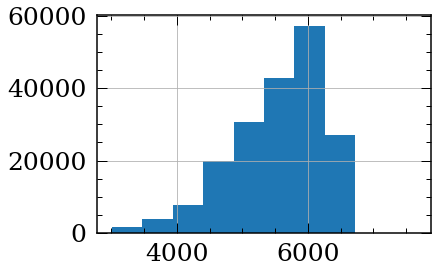

In [11]:
df['teff_calc'].hist()

Text(0, 0.5, 'logg')

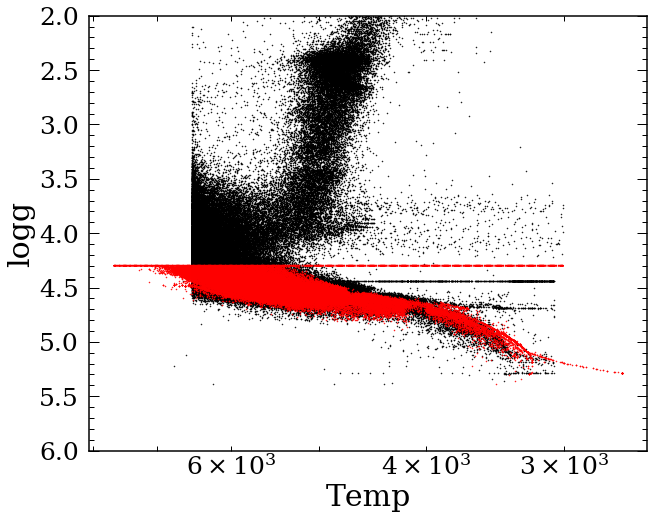

In [12]:
gcut=4.3

z = np.polyfit(df['teff_calc'], df['abs_G'], 6)
p = np.poly1d(z)
plt.figure(figsize=(10,8))
plt.semilogx(df['teff_calc'],df['logg'],'k.',markersize=1)
#plt.semilogx(df['teff'],p(df['teff'])-0.01,'r.',markersize=1)
plt.plot(df['teff_calc'],gcut*np.ones(len(df['teff'])),'r--')

df_w=df.loc[df['abs_G']>p(df['teff_calc'])-0.01]
df_w=df_w.loc[df_w['logg']>gcut]
#df_w=df_w.loc[df_w["abs_G"]>20]
plt.semilogx(df_w['teff'],df_w['logg'],'r.',markersize=1)
plt.ylim([2,6])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel('Temp')
plt.ylabel('logg')

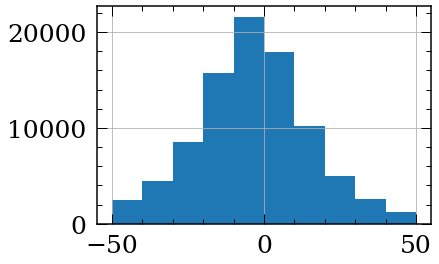

In [14]:
df_w=df_w.loc[df_w['v_b']<50]
df_w=df_w.loc[df_w['v_b']>-50]
df_w=df_w.reset_index(drop=True)
df_w['v_b'].hist()

# MS stars

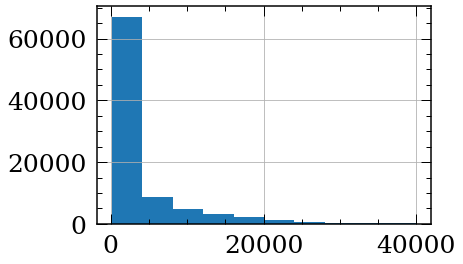

In [15]:
df_w=df_w.loc[df_w['Rvar']<4e4]
df_w['Rvar'].hist()

In [16]:
#Calcdv(df_w,'teff_calc','Rvar',150)
bintemps=[300,400,450,500,550,600,650,700]
binprots=[0.4,0.5,0.7,0.8,1.]

df_w['Rvar_log']=np.log10(df_w['Rvar'])
df_w=df_w.reset_index(drop=True)
f=open('VD_bin_rvar','w+')
f.write('KID, vd, vd_err\n')
sys.stdout.flush()
for i in range(len(df_w)):
    update_progress(i/len(df_w))
    kid, vd,vd_err=testBin(df_w,'teff_calc','Rvar_log',i, bintemps,binprots)
    f.write(str(kid)+','+str(vd)+','+str(vd_err)+'\n')
    sys.stdout.flush()
    f.flush()
    
#Calcdv(df_w,'teff_calc','Rvar',150)

Progress: [####################] 100.0%


In [23]:
df_rvar_bin=pd.read_table('VD_bin_rvar',delimiter=',')
df_rvar_bin

,KID,vd,vd_err
0,757450,10.926149,0.315749
1,892376,14.448633,0.431667
2,892718,18.939003,0.249146
3,892772,21.442488,0.472914
4,892832,19.379059,0.128349
...,...,...,...
88556,12983952,20.184545,0.242733
88557,12984012,17.958894,0.105732
88558,12984138,12.027063,0.373900
88559,12984183,18.611690,0.416309


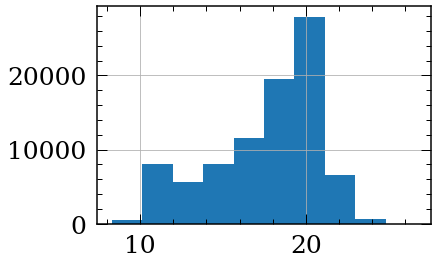

In [27]:
df_w_cm=pd.merge(df_w,df_rvar_bin,left_on='KID',right_on='KID',how='inner')
df_w_cm
df_plot=df_w_cm.loc[df_w_cm[' vd']>0]
df_plot[' vd'].hist()

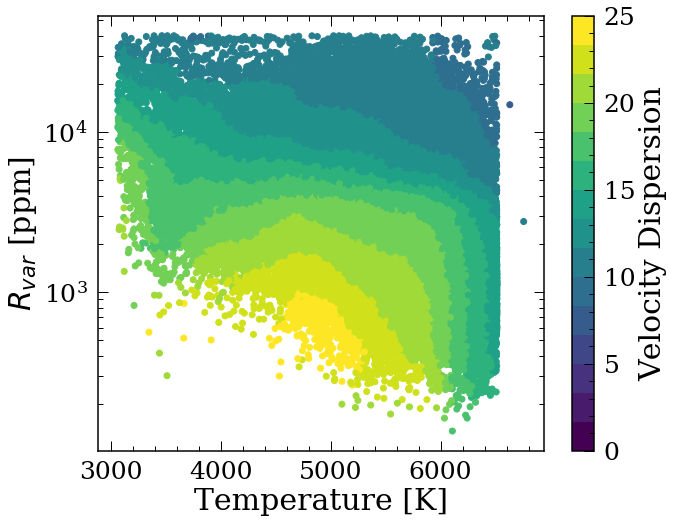

In [29]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(df_plot['teff_calc'],df_plot['Rvar'],c=df_plot[' vd'],cmap=cm,vmin=0,vmax=25)
cb=plt.colorbar()
#plt.ylim([0,50000])
cb.set_label('Velocity Dispersion')
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('$R_{var}$ [ppm]')
plt.savefig('RvarVD.png')

# Giants

In [25]:
Calcdv(df_w_giant,'teff','Rvar',150)

Progress: [####################] 100.0%


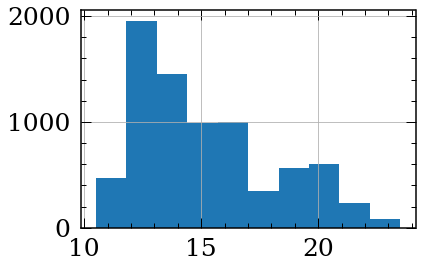

In [32]:
df_plot=df_w_giant.loc[df_w_giant['dv_recover']>0]
df_w_giant['dv_recover'].hist()

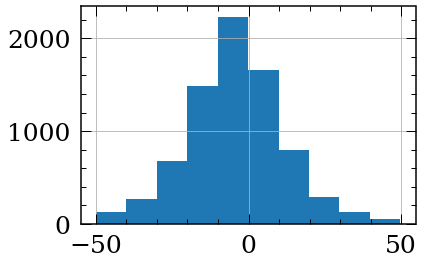

In [24]:
df_w_giant=df_w_giant.loc[df_w_giant['v_b']<50]
df_w_giant=df_w_giant.loc[df_w_giant['v_b']>-50]
df_w_giant=df_w_giant.reset_index(drop=True)
df_w_giant['v_b'].hist()

Text(0, 0.5, '$R_{var}$ [ppm]')

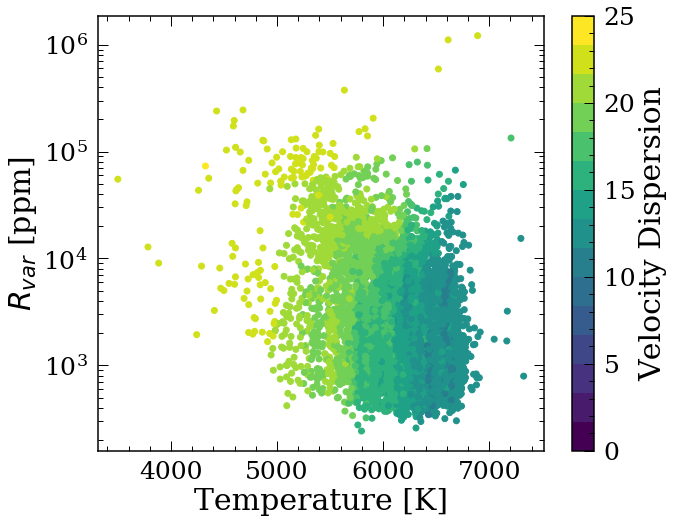

In [33]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(df_plot['teff'],df_plot['Rvar'],c=df_plot['dv_recover'],cmap=cm,vmin=0,vmax=25)
cb=plt.colorbar()
#plt.ylim([0,50000])
cb.set_label('Velocity Dispersion')
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('$R_{var}$ [ppm]')

# Get ages

In [122]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

In [30]:
#df_w_giant.to_pickle('RvarVP_Giant_150_w015_bin.pkl')
df_w_cm.to_pickle('RvarVP_MS_150_w015_bin.pkl')


0.0
NewData/RvarVP_MS_150_w015_bin.pkl


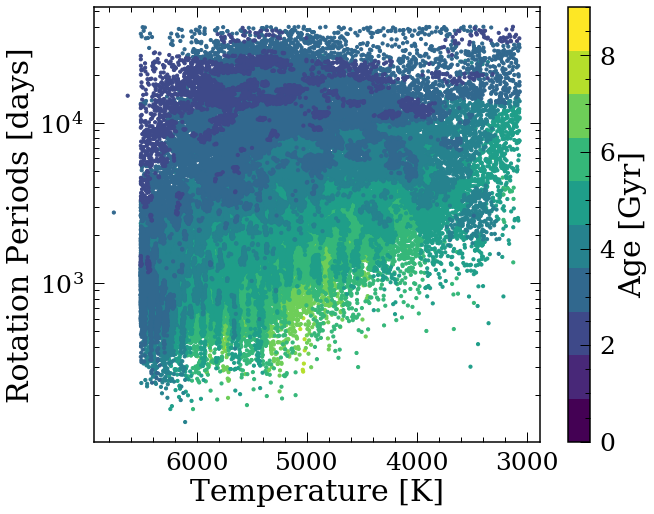

In [124]:
fname='RvarVP_MS_150_w015_bin.pkl'
theta=[9.00320811,0.28388155,-15.1689971 ]
theta_err=[0.10306229,0.00662335,0.34296342]
df_w=pd.read_pickle(fname)

#df_w['age_MAD']=AVD(df_w['dv_MAD'],*theta)
p_mp, p_mr, p_a = get_avr_coefficients()
df_w['age']=v_to_age(df_w[' vd'],p_mp)
df_w['age_err']=v_to_age(df_w[' vd_err'],p_mp)

#df_w['age_model_err']=abs(df_w['dv_MAD_err'])*df_w['age_MAD']
#df_w['age_model_err']=np.zeros(len(df_w))
#df_w['age_fit_err']=age_err(df_w['dv_MAD'],*theta,*theta_err)
#df_w['age_fit_err']=np.zeros(len(df_w))

#df_w['age_MAD_err']=np.sqrt(np.power(df_w['age_model_err'],2.)+np.power(df_w['age_fit_err'],2.))

#df_w['age_STD']=AVD(df_w['dv_STD'],*theta)

df_w=df_w.replace([np.inf, -np.inf], np.nan)
df_w=df_w.dropna(subset=['teff_calc','Rvar','age_MAD','abs_G','age_MAD_err'])
#df_w_giants['age_Prot']=p_lowz(df_w_giants['dv_STD'])

# plot tempreture vs Prot
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(10,8))
df_w=df_w.dropna(subset=['dv_MAD'])
df_plotdv=df_w[['teff_calc','Rvar','age_MAD','abs_G']].sort_values(by=['age_MAD'], ascending=False).loc[df_w['kmag']<16.]
plt.scatter(df_plotdv['teff_calc'],df_plotdv['Rvar'],c=df_plotdv['age_MAD'],s=10,vmin=0,vmax=9,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()

plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Age [Gyr]')
plt.yscale('log')
#plt.savefig('150stars_wogiant_age.png')
print(np.median(df_w['age_MAD_err']/df_w['age_MAD']))
print('NewData/'+fname)
df_w.to_pickle('NewData/'+fname)




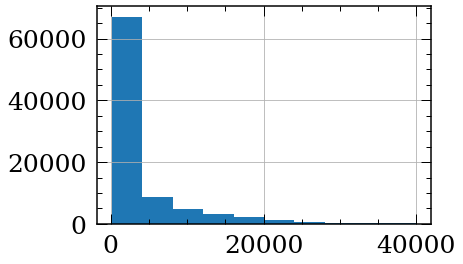

In [125]:
df_w['Rvar'].hist()

# Rvar ages abundances trend

In [3]:
APOGEE=pd.read_pickle('/Users/lucy/Desktop/ASTR/Columbia/GalacticArch/APOGEE.pkl')

df_st=pd.merge(APOGEE,pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl'),
               left_on='GAIA_SOURCE_ID',right_on='source_id',how='inner')
df_st

,APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,...,G_dered,teff_calc,v_t,v_b,abs_G,Rvar_log,vd,vd_err,age,age_err
0,apogee.apo25m.s.stars.K08_073+19.2M18411016+43...,apo25m.4409.K08_073+19.2M18411016+4308560,apogee.apo25m.s.r12-l33.K08_073+19.2M18411016+...,apStar-r12-2M18411016+4308560.fits,2M18411016+4308560,apo25m,4409,K08_073+19,9.965,0.029,...,11.833636,4313.684470,50.820542,-36.833062,6.740220,3.283365,20.816841,0.795997,5.302655,0.817816
1,apogee.apo25m.s.stars.K08_073+19.2M18412373+44...,apo25m.5008.K08_073+19.2M18412373+4403009,apogee.apo25m.s.r12-l33.K08_073+19.2M18412373+...,apStar-r12-2M18412373+4403009.fits,2M18412373+4403009,apo25m,5008,K08_073+19,12.351,0.024,...,13.470606,5515.018539,81.074555,-10.636719,5.185203,2.827204,21.635471,0.387252,5.498888,0.378788
2,apogee.apo25m.s.stars.K08_073+19.2M18413712+42...,apo25m.5008.K08_073+19.2M18413712+4255465,apogee.apo25m.s.r12-l33.K08_073+19.2M18413712+...,apStar-r12-2M18413712+4255465.fits,2M18413712+4255465,apo25m,5008,K08_073+19,12.392,0.022,...,13.542255,5457.497673,52.325243,-3.850298,5.055746,2.771108,22.061836,0.416663,5.600920,0.405636
3,apogee.apo25m.s.stars.K03_077+20.2M18415794+47...,apo25m.5003.K03_077+20.2M18415794+4748254,apogee.apo25m.s.r12-l33.K03_077+20.2M18415794+...,apStar-r12-2M18415794+4748254.fits,2M18415794+4748254,apo25m,5003,K03_077+20,12.308,0.021,...,13.380732,5679.356566,56.400614,20.467853,4.704101,2.818957,21.285850,0.275007,5.415134,0.278758
4,apogee.apo25m.s.stars.K08_073+19.2M18422582+43...,apo25m.4409.K08_073+19.2M18422582+4348093,apogee.apo25m.s.r12-l33.K08_073+19.2M18422582+...,apStar-r12-2M18422582+4348093.fits,2M18422582+4348093,apo25m,4409,K08_073+19,10.698,0.023,...,12.357700,4529.300748,20.900919,3.433018,6.588626,2.802713,23.238732,1.201456,5.881975,1.230308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,apogee.apo25m.s.stars.K14_080+08.2M20023362+46...,apo25m.4462.K14_080+08.2M20023362+4600287,apogee.apo25m.s.r12-l33.K14_080+08.2M20023362+...,apStar-r12-2M20023362+4600287.fits,2M20023362+4600287,apo25m,4462,K14_080+08,9.846,0.022,...,11.590449,4362.405526,20.240899,-8.583655,7.074000,3.600573,17.940248,0.318238,4.609427,0.324170
1134,apogee.apo25m.s.stars.K14_080+08.2M20033948+45...,apo25m.4462.K14_080+08.2M20033948+4522215,apogee.apo25m.s.r12-l33.K14_080+08.2M20033948+...,apStar-r12-2M20033948+4522215.fits,2M20033948+4522215,apo25m,4462,K14_080+08,11.278,0.019,...,12.300897,5584.517397,32.957188,-11.504926,5.155419,2.837064,21.458354,0.297180,5.456469,0.311718
1135,apogee.apo25m.s.stars.K14_080+08.2M20035116+45...,apo25m.4462.K14_080+08.2M20035116+4505338,apogee.apo25m.s.r12-l33.K14_080+08.2M20035116+...,apStar-r12-2M20035116+4505338.fits,2M20035116+4505338,apo25m,4462,K14_080+08,11.104,0.020,...,12.806608,4440.311454,7.081148,-4.842252,6.911473,3.915891,13.923521,0.480842,3.630295,0.459183
1136,apogee.apo25m.s.stars.K14_080+08.2M20050193+44...,apo25m.5014.K14_080+08.2M20050193+4436159,apogee.apo25m.s.r12-l33.K14_080+08.2M20050193+...,apStar-r12-2M20050193+4436159.fits,2M20050193+4436159,apo25m,5014,K14_080+08,11.018,0.018,...,11.618140,6377.401876,3.356129,3.285963,3.182751,2.609955,15.513785,0.538942,4.019674,0.533105


In [4]:
with fits.open('APOGEECM_allKepler') as data_ga:
    APOGEE_CM = pd.DataFrame(data_ga[1].data, dtype="float64")
df_st=pd.merge(APOGEE_CM,pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl'),
               left_on='GAIA_SOURCE_ID',right_on='source_id',how='inner')
"""
APOGEE=pd.read_pickle('/Users/lucy/Desktop/ASTR/Columbia/GalacticArch/APOGEE.pkl')
df_st=pd.merge(APOGEE,df_w,left_on='GAIA_SOURCE_ID',right_on='source_id',how='inner')
"""
df_st=df_st.drop_duplicates(subset='KID')
df_st


,APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,...,G_dered,teff_calc,v_t,v_b,abs_G,Rvar_log,vd,vd_err,age,age_err
0,apogee.apo25m.s.stars.K08_073+19.2M18412373+44...,apo25m.5008.K08_073+19.2M18412373+4403009,apogee.apo25m.s.r12-l33.K08_073+19.2M18412373+...,apStar-r12-2M18412373+4403009.fits,2M18412373+4403009,apo25m,5008.0,K08_073+19,12.351,0.024,...,13.470606,5515.018539,81.074555,-10.636719,5.185203,2.827204,21.635471,0.387252,5.498888,0.378788
1,apogee.apo25m.s.stars.K08_073+19.2M18412508+43...,apo25m.5008.K08_073+19.2M18412508+4303240,apogee.apo25m.s.r12-l33.K08_073+19.2M18412508+...,apStar-r12-2M18412508+4303240.fits,2M18412508+4303240,apo25m,5008.0,K08_073+19,12.652,0.030,...,14.545487,4117.885214,44.797153,-32.394829,7.275879,3.239367,20.707497,0.789863,5.276411,0.847346
2,apogee.apo25m.s.stars.K08_073+19.2M18413712+42...,apo25m.5008.K08_073+19.2M18413712+4255465,apogee.apo25m.s.r12-l33.K08_073+19.2M18413712+...,apStar-r12-2M18413712+4255465.fits,2M18413712+4255465,apo25m,5008.0,K08_073+19,12.392,0.022,...,13.542255,5457.497673,52.325243,-3.850298,5.055746,2.771108,22.061836,0.416663,5.600920,0.405636
3,apogee.apo25m.s.stars.K08_073+19.2M18415773+42...,apo25m.4409.K08_073+19.2M18415773+4256093,apogee.apo25m.s.r12-l33.K08_073+19.2M18415773+...,apStar-r12-2M18415773+4256093.fits,2M18415773+4256093,apo25m,4409.0,K08_073+19,9.393,0.025,...,10.657826,5226.848975,11.827114,7.904597,5.419537,4.390068,11.026335,0.209981,2.914010,0.213404
4,apogee.apo25m.s.stars.K03_077+20.2M18415794+47...,apo25m.5003.K03_077+20.2M18415794+4748254,apogee.apo25m.s.r12-l33.K03_077+20.2M18415794+...,apStar-r12-2M18415794+4748254.fits,2M18415794+4748254,apo25m,5003.0,K03_077+20,12.308,0.021,...,13.380732,5679.356566,56.400614,20.467853,4.704101,2.818957,21.285850,0.275007,5.415134,0.278758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,apogee.apo25m.s.stars.K14_080+08.2M20045645+45...,apo25m.5014.K14_080+08.2M20045645+4506082,apogee.apo25m.s.r12-l33.K14_080+08.2M20045645+...,apStar-r12-2M20045645+4506082.fits,2M20045645+4506082,apo25m,5014.0,K14_080+08,10.613,0.021,...,11.226351,6473.114271,2.054725,-1.733310,3.081051,4.133983,9.585360,0.393346,2.553820,0.383310
2000,apogee.apo25m.s.stars.K14_080+08.2M20050193+44...,apo25m.5014.K14_080+08.2M20050193+4436159,apogee.apo25m.s.r12-l33.K14_080+08.2M20050193+...,apStar-r12-2M20050193+4436159.fits,2M20050193+4436159,apo25m,5014.0,K14_080+08,11.018,0.018,...,11.618140,6377.401876,3.356129,3.285963,3.182751,2.609955,15.513785,0.538942,4.019674,0.533105
2001,apogee.apo25m.s.stars.K14_080+08.2M20050914+44...,apo25m.4462.K14_080+08.2M20050914+4412313,apogee.apo25m.s.r12-l33.K14_080+08.2M20050914+...,apStar-r12-2M20050914+4412313.fits,2M20050914+4412313,apo25m,4462.0,K14_080+08,11.283,0.019,...,13.083102,4361.878003,44.332856,-40.876197,6.863054,2.908781,22.479379,0.808301,5.700731,0.812027
2002,apogee.apo25m.s.stars.K14_080+08.2M20055093+44...,apo25m.5014.K14_080+08.2M20055093+4451599,apogee.apo25m.s.r12-l33.K14_080+08.2M20055093+...,apStar-r12-2M20055093+4451599.fits,2M20055093+4451599,apo25m,5014.0,K14_080+08,10.995,0.021,...,12.712142,4391.095386,13.783485,-2.443485,7.105989,3.608978,17.957198,0.330393,4.613530,0.330801


In [9]:
df_st=df_st.loc[abs(df_st['FE_H'])<0.1]
df_st=df_st.loc[abs(df_st['teff_calc']-5778)<=100]
df_st=df_st.loc[abs(df_st['LOGG_1']-4.43)<=0.1]

print(len(df_st))
df_ka=pd.read_table('BedellAbund.csv',delimiter=',')
df_ka.HIP=[int(i) for i in df_ka.HIP.values]
df_ka_age=pd.read_table('Bedell_age.csv',delimiter=',')
df_ka_age.HIP=[int(i) for i in df_ka_age.HIP.values]
df_fe=pd.read_table('Bedell_Fe.csv',delimiter=',')
df_fe.HIP=[int(i) for i in df_fe.HIP.values]

94


In [10]:
df_st_md=pd.merge(df_ka,df_ka_age,left_on='HIP',right_on='HIP',how='inner')
df_st_md=pd.merge(df_st_md,df_fe,left_on='HIP',right_on='HIP',how='inner')
df_st_md.columns

Index(['HIP', '[CI/H]', '[CH/H]', '[OI/H]', '[NaI/H]', '[MgI/H]', '[AlI/H]',
       '[SiI/H]', '[SI/H]', '[CaI/H]', '[ScI/H]', '[ScII/H]', '[TiI/H]',
       '[TiII/H]', '[VI/H]', '[CrI/H]', '[CrII/H]', '[MnI/H]', '[CoI/H]',
       '[NiI/H]', '[CuI/H]', '[ZnI/H]', '_RA', '_DE', 'recno', 'e_[ZnI/H]',
       'e_[VI/H]', 'e_[TiII/H]', 'e_[SiI/H]', 'e_[TiI/H]', 'e_[SI/H]',
       'e_[ScII/H]', 'e_[ScI/H]', 'e_[OI/H]', 'e_[NiI/H]', 'e_[NaI/H]',
       'e_[MnI/H]', 'e_[MgI/H]', 'e_[CuI/H]', 'e_[AlI/H]', 'e_[CaI/H]',
       'e_[CH/H]', 'e_[CI/H]', 'e_[CoI/H]', 'e_[CrI/H]', 'e_[CrII/H]',
       'RAJ2000_x', 'DEJ2000_x', 'Agemp', 'AgeLL1s', 'AgeUL1s', 'AgeLL2s',
       'AgeUL2s', 'Agemean', 'Agestd', 'Massmp', 'MassLL1s', 'MassUL1s',
       'MassLL2s', 'MassUL2s', 'MassMean', 'MassStd', 'RAJ2000_y', 'DEJ2000_y',
       'SNR', 'Teff', 'e_Teff', 'logg', 'e_logg', '[Fe/H]', 'e_[Fe/H]', 'Xi',
       'e_Xi'],
      dtype='object')

In [11]:
abun_apog=['C_FE','MG_FE','AL_FE','SI_FE','S_FE','CA_FE','TI_FE','CR_FE','MN_FE','CO_FE',
       'NI_FE','CU_FE']

abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/'}

Progress: [##################--] 91.7%


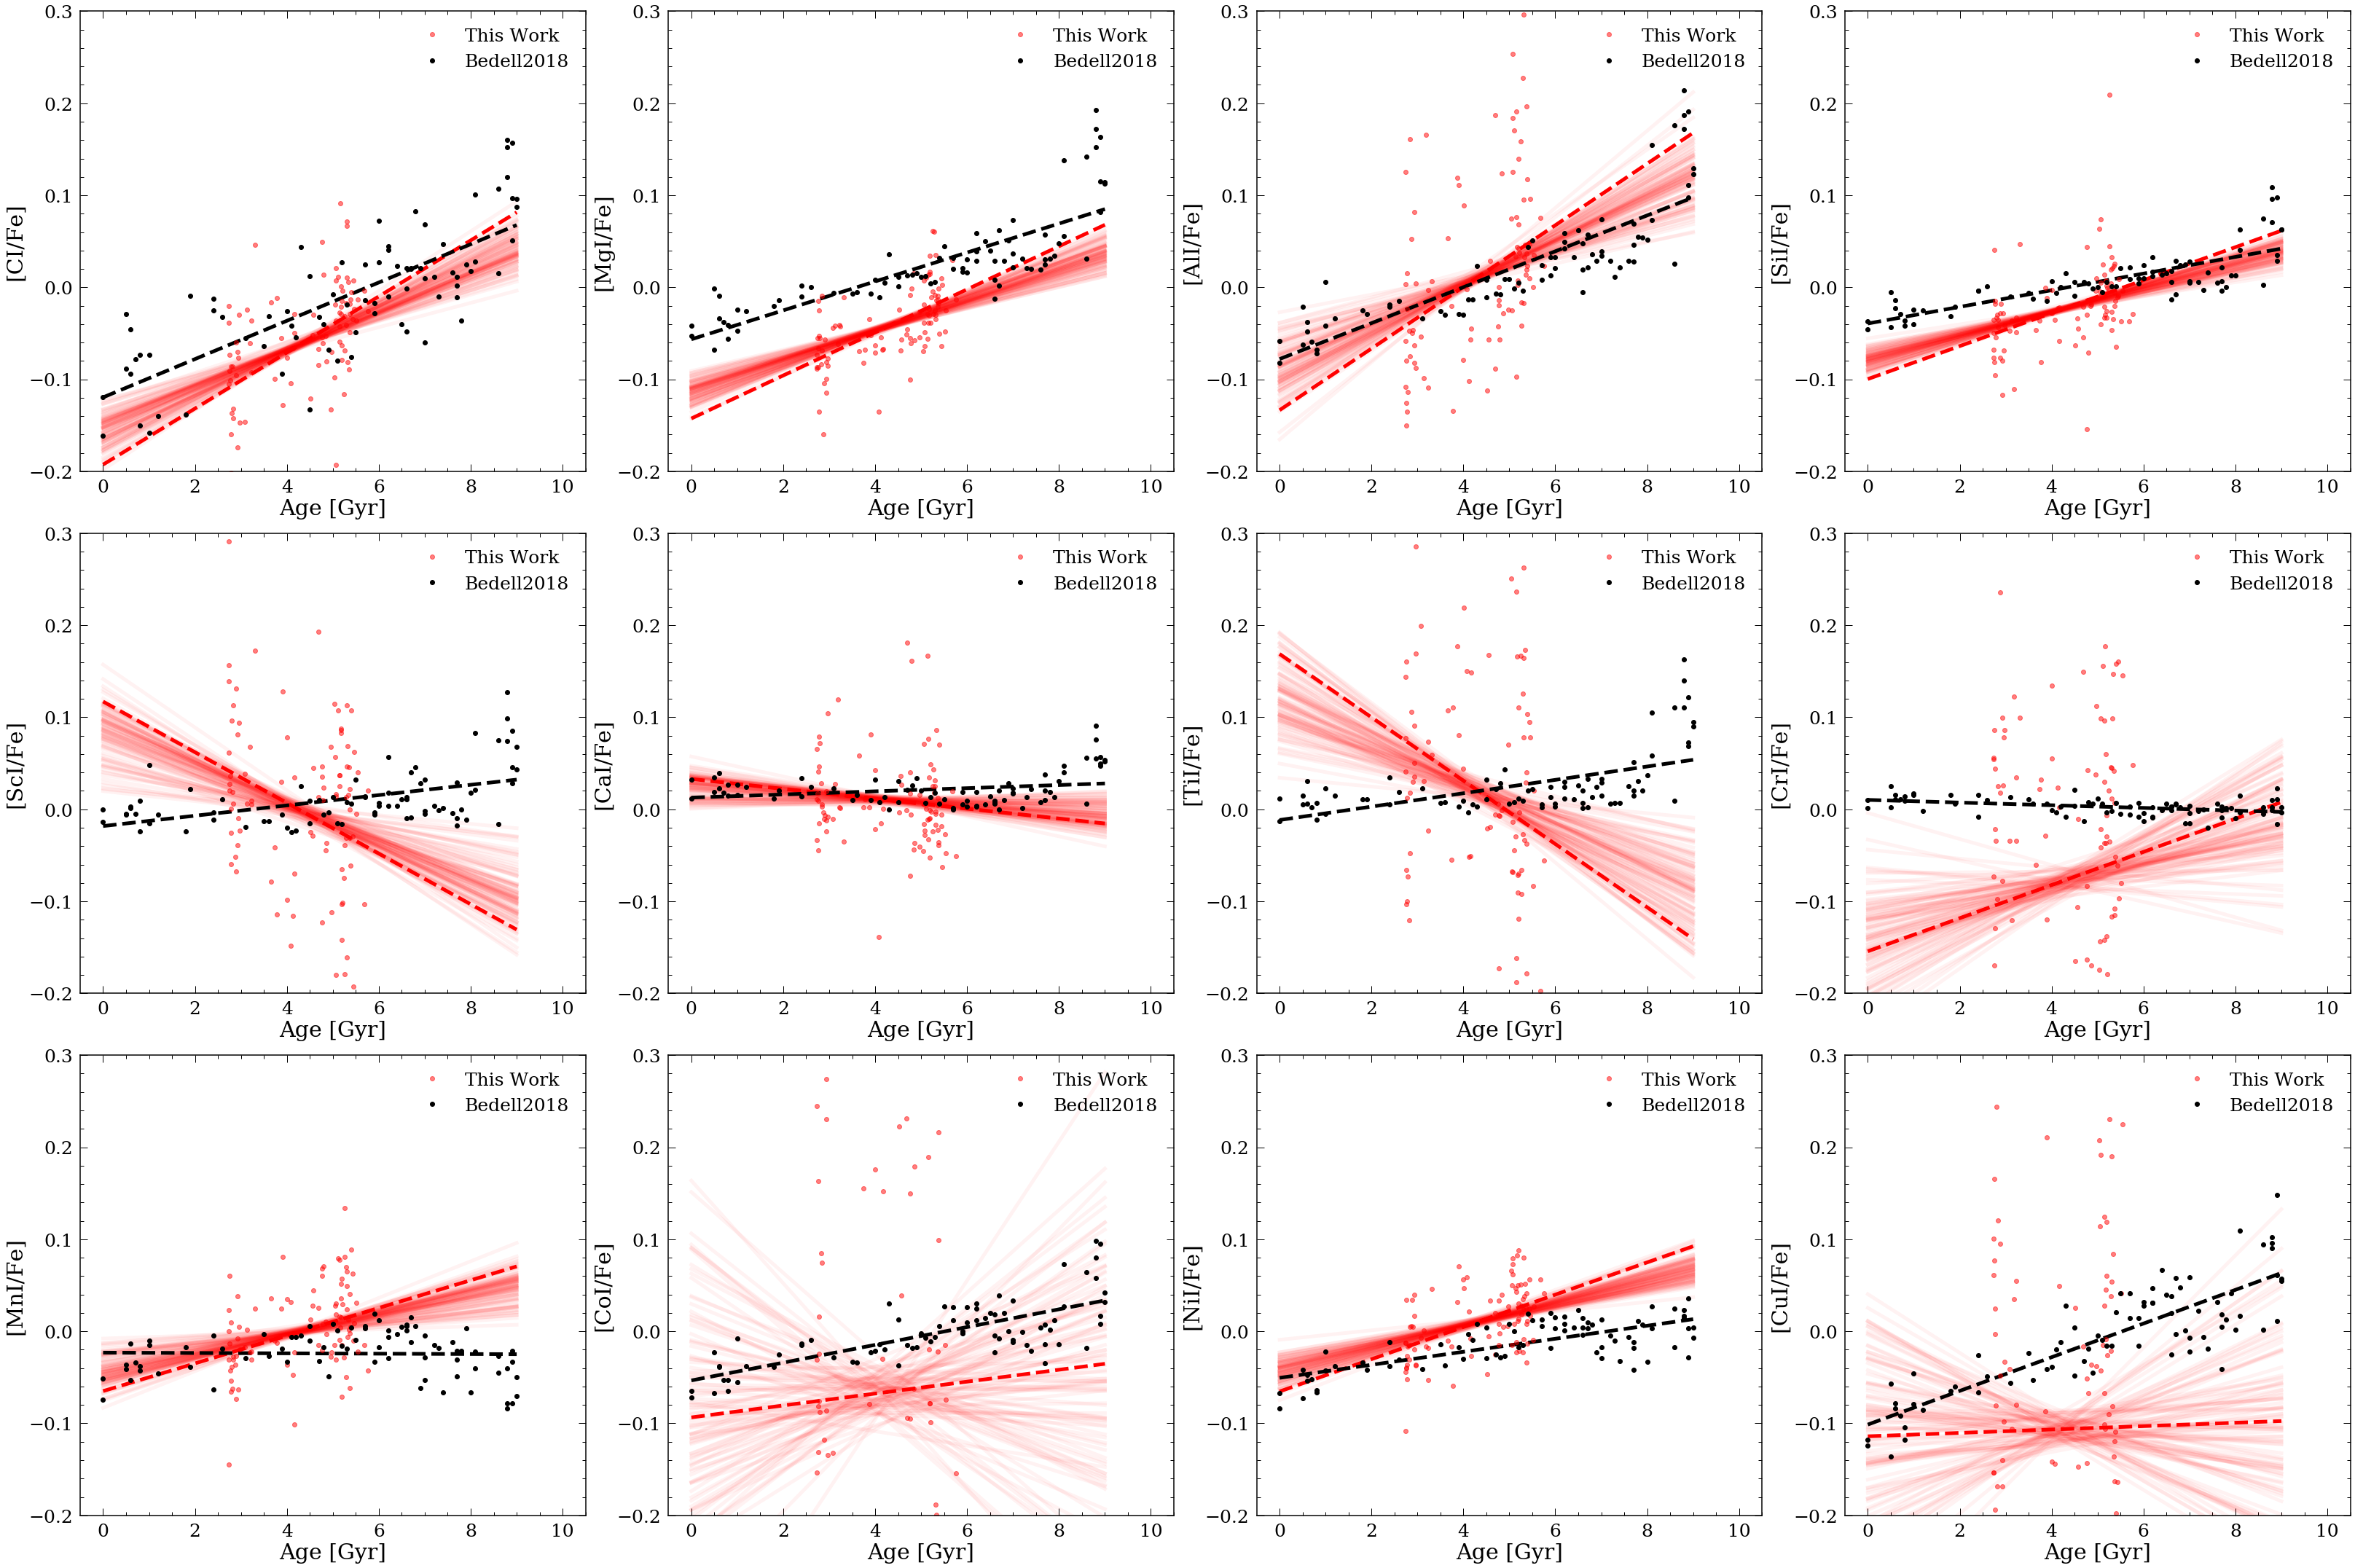

In [12]:
plotv='age'
plt.figure(figsize=(45,30))
for i in range(len(abun_apog)):
    update_progress(i/len(abun_apog))
    df_plot=df_st.loc[df_st[abun_apog[i]]>-100]
    df_plot=df_plot.reset_index(drop=True)
    plt.subplot(3,4,i+1)
    
    #err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)+np.power(df_plot["age_STD_err"],2.)
    err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)
    
    """
    plt.errorbar(df_plot[plotv],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],
                 xerr=df_plot[plotv+'_err'],fmt='ro',label='This Work',alpha=0.5)
    """
    #plt.errorbar(df_plot[plotv],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],fmt='ro',label='This Work',alpha=0.5)
    plt.errorbar(df_plot[plotv],df_plot[abun_apog[i]],fmt='ro',label='This Work',alpha=0.5)
    
    z = np.polyfit(df_plot[plotv],df_plot[abun_apog[i]],1)
    p = np.poly1d(z)
    plt.plot(range(10),p(range(10)),'r--',linewidth=5)
        
    for k in range(100):
        new_age_mock=np.array([np.random.normal(df_plot.iloc[j][plotv],
                        df_plot.iloc[j][plotv+'_err']) for j in range(len(df_plot))])
        new_abun_mock=np.array([np.random.normal(df_plot.iloc[j][abun_apog[i]], 
                        df_plot.iloc[j][abun_apog[i]+"_ERR"]) for j in range(len(df_plot))])
        z = np.polyfit(new_age_mock,new_abun_mock,1)
        p = np.poly1d(z)
        plt.plot(range(10),p(range(10)),'r-',linewidth=5,alpha=0.05)
    
    z = np.polyfit(df_st_md['Agemp'], df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],1)
    p = np.poly1d(z)
    
    plt.errorbar(df_st_md['Agemp'],df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],
                 fmt='ko',label='Bedell2018')
    plt.plot(range(10),p(range(10)),'k--',linewidth=5)
    
    
    plt.ylim([-0.2,0.3])
    plt.xlim([-0.5,10.5])
    plt.ylabel(abund[abun_apog[i]]+'Fe]')
    plt.xlabel('Age [Gyr]')
    plt.legend()
plt.tight_layout()
plt.savefig('Abundances_Rvar.png')
    
    